In [1]:
import os
import numpy as np
import rasterio

In [2]:
ndvi_paths = {
    "date1": "output/ndvi/ndvi_date1.tif",
    "date2": "output/ndvi/ndvi_date2.tif"
}

In [3]:
def read_ndvi(path):
    with rasterio.open(path) as src:
        data = src.read(1)
        profile = src.profile
    return data, profile

ndvi_1, profile = read_ndvi(ndvi_paths["date1"])
ndvi_2, _ = read_ndvi(ndvi_paths["date2"])


In [4]:
delta_ndvi = ndvi_2 - ndvi_1

In [5]:
threshold = 0.15

change_mask = np.zeros_like(delta_ndvi, dtype=np.uint8)

change_mask[delta_ndvi > threshold] = 1    # Vegetation increase
change_mask[delta_ndvi < -threshold] = 2   # Vegetation decrease


In [7]:
os.makedirs("output/change", exist_ok=True)

delta_profile = profile.copy()
delta_profile.update(dtype="float32", nodata=np.nan)

with rasterio.open("output/delta_ndvi.tif", "w", **delta_profile) as dst:
    dst.write(delta_ndvi, 1)

print("ΔNDVI saved")


ΔNDVI saved


Change Detection Method:
Vegetation change was assessed using NDVI differencing between peak and early season imagery. A threshold of ±0.15 was applied to identify significant vegetation increase or decrease, balancing sensitivity and noise reduction.

In [9]:
mask_profile = profile.copy()
mask_profile.update(dtype="uint8", nodata=0)

with rasterio.open("output/ndvi_change_mask.tif", "w", **mask_profile) as dst:
    dst.write(change_mask, 1)

print("Change mask saved")


Change mask saved


Visualization

In [14]:
import matplotlib.pyplot as plt

In [15]:

print("Feb NDVI min/max:", np.nanmin(ndvi_1), np.nanmax(ndvi_1))
print("Apr NDVI min/max:", np.nanmin(ndvi_2), np.nanmax(ndvi_2))


Feb NDVI min/max: -0.95300263 0.9995702
Apr NDVI min/max: -0.4853147 0.84287614


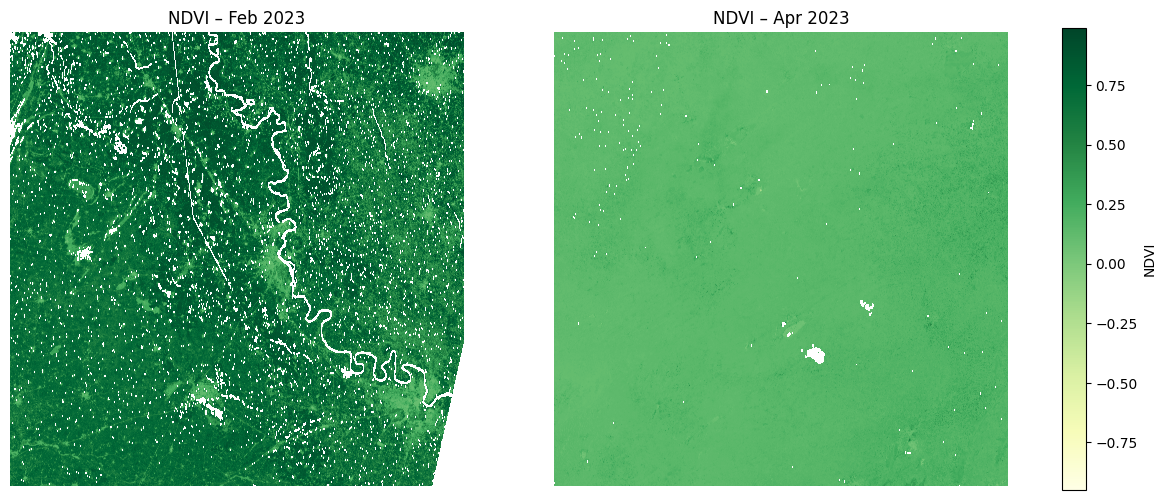

In [12]:
from matplotlib import pyplot as plt
vmin = -0.95
vmax = 0.99

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(ndvi_1, cmap="YlGn", vmin=vmin, vmax=vmax)
axes[0].set_title("NDVI – Feb 2023")
axes[0].axis("off")

axes[1].imshow(ndvi_2, cmap="YlGn", vmin=vmin, vmax=vmax)
axes[1].set_title("NDVI – Apr 2023")
axes[1].axis("off")

plt.colorbar(
    plt.cm.ScalarMappable(cmap="YlGn", norm=plt.Normalize(vmin=vmin, vmax=vmax)),
    ax=axes,
    fraction=0.03,
    label="NDVI"
)
plt.show()


In [13]:
print("Feb NDVI mean:", np.nanmean(ndvi_1))
print("Apr NDVI mean:", np.nanmean(ndvi_2))


Feb NDVI mean: 0.65801483
Apr NDVI mean: 0.15707886


In [14]:
np.isnan(ndvi_2).mean()

0.0008491677200805571

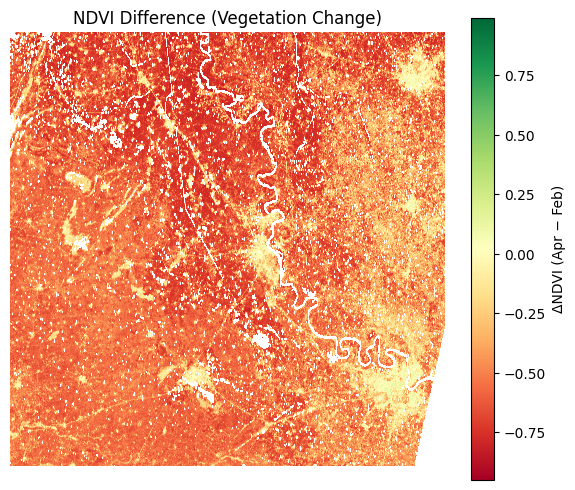

In [15]:
plt.figure(figsize=(7, 6))
plt.imshow(delta_ndvi, cmap="RdYlGn", vmin=-0.95, vmax=0.99)
plt.colorbar(label="ΔNDVI (Apr − Feb)")
plt.title("NDVI Difference (Vegetation Change)")
plt.axis("off")
plt.show()

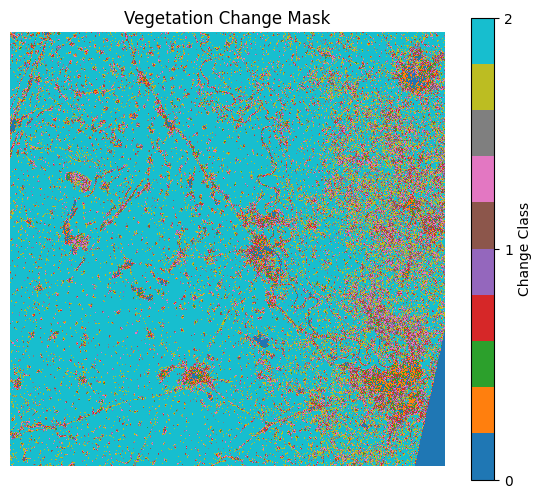

In [16]:
plt.figure(figsize=(7, 6))
plt.imshow(change_mask, cmap="tab10", vmin=0, vmax=2)
plt.colorbar(ticks=[0, 1, 2], label="Change Class")
plt.title("Vegetation Change Mask")
plt.axis("off")
plt.show()

Visualization Summary:
NDVI maps indicate a clear increase in vegetation density from February to April, consistent with seasonal crop growth. The ΔNDVI map highlights spatial variability in vegetation change, while the classified change mask isolates regions of significant increase or decrease for further analysis.

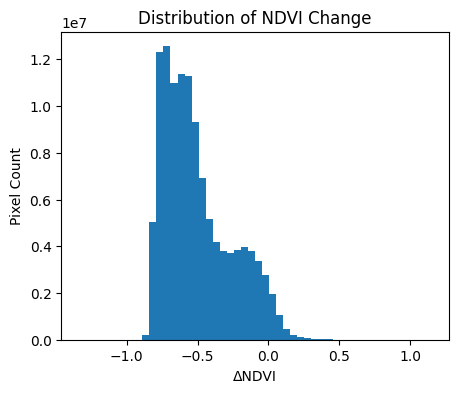

In [17]:
plt.figure(figsize=(5,4))
plt.hist(delta_ndvi[~np.isnan(delta_ndvi)].ravel(), bins=50)
plt.xlabel("ΔNDVI")
plt.ylabel("Pixel Count")
plt.title("Distribution of NDVI Change")
plt.show()